In [1]:
# 📌 Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


In [8]:
# 📌 Cell 2: Configurations
FEATURES = [
    "Vibration_Amplitude",
    "RMS_Vibration",
    "Vibration_Frequency",
    "Surface_Temperature",
    "Exhaust_Temperature",
    "Acoustic_dB",
    "Acoustic_Frequency",
    "Intake_Pressure",
    "Exhaust_Pressure",
    "Frequency_Band_Energy",
    "Amplitude_Mean"
]


CONTAMINATION = 0.03  # expected fraction of anomalies
RANDOM_STATE = 42


In [9]:
import os

folder = r"D:\Vehicle-Diagnostics-Chatbot-Cognizant\data"
print("Files in folder:")
print(os.listdir(folder))


Files in folder:
['engine_fault_detection_dataset.csv', 'obd_codes.json']


In [5]:
df = pd.read_csv(r"D:\Vehicle-Diagnostics-Chatbot-Cognizant\data\engine_fault_detection_dataset.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (10000, 12)


,Vibration_Amplitude,RMS_Vibration,Vibration_Frequency,Surface_Temperature,Exhaust_Temperature,Acoustic_dB,Acoustic_Frequency,Intake_Pressure,Exhaust_Pressure,Frequency_Band_Energy,Amplitude_Mean,Engine_Condition
0,3.807947,1.899522,1465.396656,106.577348,319.564816,110.834195,3733.620495,91.279833,104.544934,0.889443,0.294582,0
1,9.512072,1.697915,385.333751,85.115094,237.927110,89.671023,4417.399188,114.855139,84.358093,0.916455,0.268216,0
2,7.346740,0.921962,706.346595,145.739823,250.543690,71.727937,2369.581389,97.479227,108.393914,0.440535,0.182008,0
3,6.026719,3.055970,1333.295661,56.277414,272.268451,104.198507,1516.975785,98.518121,105.296723,0.308468,0.251674,2
4,1.644585,2.409290,974.536902,100.542770,281.461334,85.120688,1662.348214,96.787358,107.565599,0.272495,0.188897,0


In [7]:
# List all columns in your dataset
print(df.columns.tolist())


['Vibration_Amplitude', 'RMS_Vibration', 'Vibration_Frequency', 'Surface_Temperature', 'Exhaust_Temperature', 'Acoustic_dB', 'Acoustic_Frequency', 'Intake_Pressure', 'Exhaust_Pressure', 'Frequency_Band_Energy', 'Amplitude_Mean', 'Engine_Condition']


In [10]:
# 📌 Cell 4: Preprocess (fill missing + scale)
from sklearn.preprocessing import StandardScaler

X = df[FEATURES].copy()

# Fill missing values
X = X.interpolate().ffill().bfill()
X = X.fillna(X.median())

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-0.41590018, -0.45246481,  0.80188444,  0.482494  , -0.68431555,
         1.19340937,  0.83355632, -1.59663356,  1.08737661,  1.32696517,
         0.27929302],
       [ 1.58737745, -0.59325819, -1.10035932, -0.13641397, -1.38986562,
        -0.02992279,  1.31869383,  1.15151533, -1.2199121 ,  1.43127943,
         0.09262934],
       [ 0.82691712, -1.13514888, -0.53498051,  1.61182405, -1.28082742,
        -1.06711864, -0.13422252, -0.87397659,  1.52730224, -0.40661997,
        -0.51770721],
       [ 0.36332825,  0.35514644,  0.56922365, -0.96800746, -1.09307218,
         0.80983502, -0.73914187, -0.75287386,  1.17330369, -0.91663555,
        -0.02448427],
       [-1.17566901, -0.09646608, -0.06263456,  0.3084746 , -1.01362312,
        -0.2929538 , -0.63600087, -0.95462705,  1.43262861, -1.05555427,
        -0.46893264]])

In [11]:
# 📌 Cell 5: Train Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(X_scaled)

scores = -iso.decision_function(X_scaled)  # higher = more anomalous
labels = iso.predict(X_scaled)             # -1 = anomaly, 1 = normal
labels = (labels == -1).astype(int)        # convert to 1=anomaly, 0=normal

df["anomaly_score"] = scores
df["anomaly_label"] = labels

df.head()



,Vibration_Amplitude,RMS_Vibration,Vibration_Frequency,Surface_Temperature,Exhaust_Temperature,Acoustic_dB,Acoustic_Frequency,Intake_Pressure,Exhaust_Pressure,Frequency_Band_Energy,Amplitude_Mean,Engine_Condition,anomaly_score,anomaly_label
0,3.807947,1.899522,1465.396656,106.577348,319.564816,110.834195,3733.620495,91.279833,104.544934,0.889443,0.294582,0,-0.067115,0
1,9.512072,1.697915,385.333751,85.115094,237.927110,89.671023,4417.399188,114.855139,84.358093,0.916455,0.268216,0,-0.021030,0
2,7.346740,0.921962,706.346595,145.739823,250.543690,71.727937,2369.581389,97.479227,108.393914,0.440535,0.182008,0,-0.049991,0
3,6.026719,3.055970,1333.295661,56.277414,272.268451,104.198507,1516.975785,98.518121,105.296723,0.308468,0.251674,2,-0.094594,0
4,1.644585,2.409290,974.536902,100.542770,281.461334,85.120688,1662.348214,96.787358,107.565599,0.272495,0.188897,0,-0.089316,0


Anomaly counts:
anomaly_label
0    9700
1     300
Name: count, dtype: int64


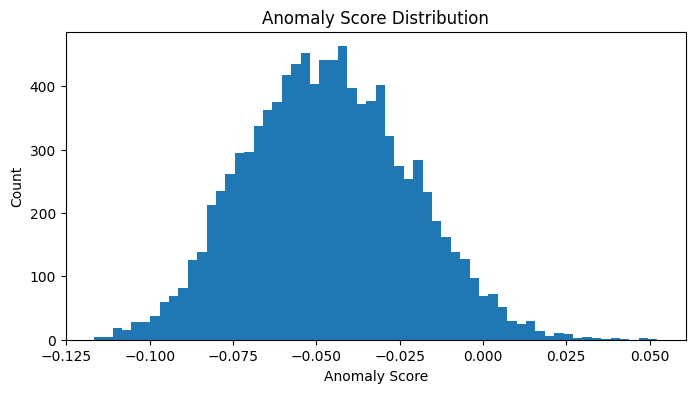

In [12]:
# 📌 Cell 6: Anomaly summary
print("Anomaly counts:")
print(df["anomaly_label"].value_counts())

plt.figure(figsize=(8,4))
plt.hist(df["anomaly_score"], bins=60)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()


In [18]:
# Compute approximate feature importance using correlation with anomaly score
importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_score": [np.corrcoef(X_scaled[:, i], scores)[0,1] for i in range(len(FEATURES))]
}).sort_values("importance_score", key=abs, ascending=False)

display(importance_df)

# Plot




,feature,importance_score
8,Exhaust_Pressure,-0.056831
9,Frequency_Band_Energy,0.053448
1,RMS_Vibration,-0.049023
3,Surface_Temperature,0.045972
7,Intake_Pressure,0.033152
0,Vibration_Amplitude,0.029949
10,Amplitude_Mean,-0.014073
5,Acoustic_dB,0.012665
2,Vibration_Frequency,0.003671
6,Acoustic_Frequency,0.002967


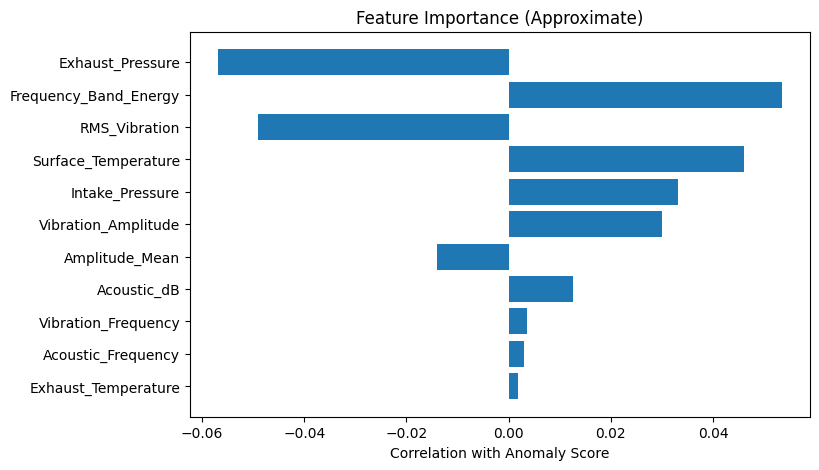

In [16]:
plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance_score"])
plt.xlabel("Correlation with Anomaly Score")
plt.title("Feature Importance (Approximate)")
plt.gca().invert_yaxis()
plt.show()


In [19]:
def check_single_input(user_dict):
    row = pd.DataFrame([user_dict])[FEATURES]
    row_scaled = scaler.transform(row)
    score = -iso.decision_function(row_scaled)[0]
    pred = iso.predict(row_scaled)[0]
    label = "ANOMALY" if pred == -1 else "NORMAL"
    return {"label": label, "anomaly_score": score}


In [21]:
sample_input = {
    "Vibration_Amplitude": 0.45,
    "RMS_Vibration": 0.12,
    "Vibration_Frequency": 300.0,
    "Surface_Temperature": 85.0,
    "Exhaust_Temperature": 450.0,
    "Acoustic_dB": 72.0,
    "Acoustic_Frequency": 1000.0,
    "Intake_Pressure": 1.2,
    "Exhaust_Pressure": 1.0,
    "Frequency_Band_Energy": 55.0,
    "Amplitude_Mean": 0.3
}

check_single_input(sample_input)


{'label': 'ANOMALY', 'anomaly_score': np.float64(0.02414472965716874)}

In [23]:
# 📌 Cell 12: Model Evaluation and Scoring
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Since we don't have true labels, we'll evaluate based on the model's own predictions
# and provide some useful metrics

print("=== MODEL EVALUATION METRICS ===\n")

# 1. Basic statistics about predictions
print(f"Total samples: {len(df)}")
print(f"Predicted anomalies: {sum(df['anomaly_label'])}")
print(f"Predicted normal: {sum(df['anomaly_label'] == 0)}")
print(f"Anomaly rate: {sum(df['anomaly_label']) / len(df) * 100:.2f}%")
print()

# 2. Anomaly score statistics
print("=== ANOMALY SCORE STATISTICS ===")
print(f"Mean anomaly score: {df['anomaly_score'].mean():.4f}")
print(f"Std anomaly score: {df['anomaly_score'].std():.4f}")
print(f"Min anomaly score: {df['anomaly_score'].min():.4f}")
print(f"Max anomaly score: {df['anomaly_score'].max():.4f}")
print()

# 3. Threshold analysis
threshold = np.percentile(df['anomaly_score'], (1 - CONTAMINATION) * 100)
print(f"Decision threshold (based on contamination={CONTAMINATION}): {threshold:.4f}")
print()

# 4. Model parameters and configuration
print("=== MODEL CONFIGURATION ===")
print(f"Model type: Isolation Forest")
print(f"Number of estimators: {iso.n_estimators}")
print(f"Contamination rate: {iso.contamination}")
print(f"Random state: {iso.random_state}")
print()

# 5. Feature importance summary
print("=== TOP 5 MOST IMPORTANT FEATURES ===")
top_features = importance_df.head(5)
for idx, row in top_features.iterrows():
    print(f"{row['feature']}: {abs(row['importance_score']):.4f}")

=== MODEL EVALUATION METRICS ===

Total samples: 10000
Predicted anomalies: 300
Predicted normal: 9700
Anomaly rate: 3.00%

=== ANOMALY SCORE STATISTICS ===
Mean anomaly score: -0.0466
Std anomaly score: 0.0244
Min anomaly score: -0.1168
Max anomaly score: 0.0524

Decision threshold (based on contamination=0.03): -0.0000

=== MODEL CONFIGURATION ===
Model type: Isolation Forest
Number of estimators: 200
Contamination rate: 0.03
Random state: 42

=== TOP 5 MOST IMPORTANT FEATURES ===
Exhaust_Pressure: 0.0568
Frequency_Band_Energy: 0.0534
RMS_Vibration: 0.0490
Surface_Temperature: 0.0460
Intake_Pressure: 0.0332
